In [1]:
import pandas as pd
import random
import math
import io
import requests
import datetime
import time
from collections import deque

In [2]:
# covid19 = pd.read_csv("/Users/avinash/Desktop/Spring 2020/Advanced Algorithms/Final Project/Safest-path-through-corona-affected-regions/Counties_Info.csv")
covid19 = pd.read_csv("Counties_info.csv")

In [3]:
covid19.head()

,Source,Destination,Time,Confirmed,2019 Census
0,Clayton,DeKalb,26,869,"292,256"
1,Clayton,Fayette,22,99,"114,421"
2,Clayton,Fulton,26,1467,"1,063,937"
3,Clayton,Henry,27,260,"234,561"
4,Cobb,Douglas,30,153,"146,343"


# Preparing the input dictionary for A* algorithm with neighbor and time information

In [4]:
input_dict = {}
for src in covid19['Source']:  
    input_dict[src.lower()] = []
    

for key in input_dict:
    for src,dest,time_value,conf,census in zip(covid19['Source'],covid19['Destination'],covid19['Time'],covid19['Confirmed'],covid19['2019 Census']):
        if(key == src.lower()):
            input_dict[key].append((dest.lower(),round(int(time_value)*(int(conf)/int(census.replace(',','')))*1000)))

In [5]:
print(input_dict)

{'clayton': [('dekalb', 77), ('fayette', 19), ('fulton', 36), ('henry', 30)], 'cobb': [('douglas', 31), ('fulton', 36)], 'coweta': [('fayette', 22), ('fulton', 66)], 'dekalb': [('clayton', 33), ('gwinnett', 19), ('fulton', 33), ('henry', 43)], 'douglas': [('cobb', 28), ('fulton', 41)], 'fulton': [('clayton', 32), ('cobb', 24), ('coweta', 33), ('dekalb', 71), ('douglas', 31), ('fayette', 36), ('gwinnett', 24)], 'gwinnett': [('dekalb', 77), ('fulton', 44)], 'fayette': [('clayton', 27), ('fulton', 58), ('coweta', 18)], 'henry': [('clayton', 33), ('dekalb', 116)]}


# Heuristic information for each county

In [6]:
h_org = {}
for dest, conf, census in zip (covid19['Destination'],covid19['Confirmed'],covid19['2019 Census']):
    h_org[dest.lower()] = round((int(conf)/int(census.replace(',','')))*1000)

In [7]:
h_org

{'dekalb': 3,
 'fayette': 1,
 'fulton': 1,
 'henry': 1,
 'douglas': 1,
 'clayton': 1,
 'gwinnett': 1,
 'cobb': 1,
 'coweta': 1}

# Getting most recent(5 days) COVID-19 information 

In [8]:
today = datetime.date.today().strftime('%m/%d/%Y')

date_1 = datetime.datetime.strptime(str(today), "%m/%d/%Y")
start_date = date_1 + datetime.timedelta(days=-6)
end_date = date_1 + datetime.timedelta(days=-1)

start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
date_array = (start + datetime.timedelta(days=x) for x in range(0, (end - start).days))
dates = []
for date_object in date_array:
    dates.append(str(date_object.strftime("%m-%d-%Y")))
print(dates)

['04-14-2020', '04-15-2020', '04-16-2020', '04-17-2020', '04-18-2020']


In [9]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
c = []
for date in dates:
    s = requests.get(url + date + ".csv").content
    c.append(pd.read_csv(io.StringIO(s.decode('utf-8'))))

# Heuristics for most recent COVID-19 information

In [10]:
h_upt = []
h1_intial = {}
for i in range(len(c)): 
    for county, state, confirmed in zip(c[i]['Admin2'], c[i]['Province_State'], c[i]['Confirmed']):
        if (state == 'Georgia'):
            if county.lower() in h_org:
                h1_intial[county.lower()] = confirmed
    h_upt.append(h1_intial)
    h1_intial = {}

In [11]:
h_upt

[{'clayton': 435,
  'cobb': 895,
  'coweta': 135,
  'dekalb': 1144,
  'douglas': 189,
  'fayette': 115,
  'fulton': 1812,
  'gwinnett': 815,
  'henry': 306},
 {'clayton': 456,
  'cobb': 924,
  'coweta': 136,
  'dekalb': 1191,
  'douglas': 197,
  'fayette': 120,
  'fulton': 1844,
  'gwinnett': 852,
  'henry': 321},
 {'clayton': 468,
  'cobb': 990,
  'coweta': 140,
  'dekalb': 1247,
  'douglas': 202,
  'fayette': 124,
  'fulton': 1929,
  'gwinnett': 896,
  'henry': 330},
 {'clayton': 491,
  'cobb': 1072,
  'coweta': 149,
  'dekalb': 1349,
  'douglas': 220,
  'fayette': 133,
  'fulton': 2025,
  'gwinnett': 1017,
  'henry': 344},
 {'clayton': 505,
  'cobb': 1100,
  'coweta': 156,
  'dekalb': 1396,
  'douglas': 226,
  'fayette': 135,
  'fulton': 2054,
  'gwinnett': 1050,
  'henry': 353}]

In [12]:
heuristic_list = []
heuristic_dict = {}
for heuristic in h_upt:
    for county, census in zip(covid19['Destination'],covid19['2019 Census']):
        val = round((int(heuristic[county.lower()])/int(census.replace(',','')))* 1000)
        if heuristic[county.lower()] not in heuristic_dict:
            heuristic_dict[county.lower()] = val
    heuristic_list.append(heuristic_dict)
    heuristic_dict = {}

In [13]:
heuristic_list

[{'dekalb': 4,
  'fayette': 1,
  'fulton': 2,
  'henry': 1,
  'douglas': 1,
  'clayton': 1,
  'gwinnett': 1,
  'cobb': 1,
  'coweta': 1},
 {'dekalb': 4,
  'fayette': 1,
  'fulton': 2,
  'henry': 1,
  'douglas': 1,
  'clayton': 2,
  'gwinnett': 1,
  'cobb': 1,
  'coweta': 1},
 {'dekalb': 4,
  'fayette': 1,
  'fulton': 2,
  'henry': 1,
  'douglas': 1,
  'clayton': 2,
  'gwinnett': 1,
  'cobb': 1,
  'coweta': 1},
 {'dekalb': 5,
  'fayette': 1,
  'fulton': 2,
  'henry': 1,
  'douglas': 2,
  'clayton': 2,
  'gwinnett': 1,
  'cobb': 1,
  'coweta': 1},
 {'dekalb': 5,
  'fayette': 1,
  'fulton': 2,
  'henry': 2,
  'douglas': 2,
  'clayton': 2,
  'gwinnett': 1,
  'cobb': 1,
  'coweta': 1}]

# Working of A* Algorithm

In [14]:

class Graph:
    # example of adjacency list (or rather map)
    # adjacency_list = {
    # 'A': [('B', 1), ('C', 3), ('D', 7)],
    # 'B': [('D', 5)],
    # 'C': [('D', 12)]
    # }

    def __init__(self, adjacency_list):
        self.adjacency_list = adjacency_list

    def get_neighbors(self, v):
        return self.adjacency_list[v]

    # heuristic function with equal values for all nodes
    def h(self, n, H):
        return H[n]

    def a_star_algorithm(self, start_node, stop_node):
        # open_list is a list of nodes which have been visited, but who's neighbors
        # haven't all been inspected, starts off with the start node
        # closed_list is a list of nodes which have been visited
        # and who's neighbors have been inspected
        open_list = {start_node}
        closed_list = set([])

        # g contains current distances from start_node to all other nodes
        # the default value (if it's not found in the map) is +infinity
        g = {}
        H = h_org
        g[start_node] = 0

        # parents contains an adjacency map of all nodes
        parents = {start_node: start_node}
        
        while len(open_list) > 0:
            n = None
            n1 = None
            # find a node with the lowest value of f() - evaluation function
            for v in open_list:
                if n is None or g[v] + self.h(v, H) < g[n] + self.h(n, H):
                    n = v;

            print("Checking for updated values")
            time.sleep(2)
            H = random.choice(heuristic_list)
            print(H)
#             currentNode = n
#             temp_path = []
#             while parents[n] != n:
#                 temp_path.append(n)
#                 n = parents[n]
#             temp_path.append(start_node)
#             temp_path.reverse()
#             n = currentNode
#             if len(temp_path) > 0: print(temp_path)
            if n is None:
                print('Path does not exist!')
                return None
            # if the current node is the stop_node
            # then we begin reconstructin the path from it to the start_node
            if n == stop_node:
                reconst_path = []

                while parents[n] != n:
                    reconst_path.append(n)
                    n = parents[n]

                reconst_path.append(start_node)

                reconst_path.reverse()

                print('Final path found: {}'.format(reconst_path))
                return reconst_path

            # for all neighbors of the current node do
            for (m, weight) in self.get_neighbors(n):
                # if the current node isn't in both open_list and closed_list
                # add it to open_list and note n as it's parent
                if m not in open_list and m not in closed_list:
                    open_list.add(m)
                    parents[m] = n
                    g[m] = g[n] + weight
                # otherwise, check if it's quicker to first visit n, then m
                # and if it is, update parent data and g data
                # and if the node was in the closed_list, move it to open_list
                else:
                    if g[m] > g[n] + weight:
                        g[m] = g[n] + weight
                        parents[m] = n

                        if m in closed_list:
                            closed_list.remove(m)
                            open_list.add(m)

            # remove n from the open_list, and add it to closed_list
            # because all of his neighbors were inspected
            open_list.remove(n)
            closed_list.add(n)
        print('Path does not exist!')
        return None

In [15]:
graph1 = Graph(input_dict)
graph1.a_star_algorithm('cobb', 'coweta')

Checking for updated values
{'dekalb': 5, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 2, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 4, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 1, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 5, 'fayette': 1, 'fulton': 2, 'henry': 2, 'douglas': 2, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 5, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 2, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 5, 'fayette': 1, 'fulton': 2, 'henry': 2, 'douglas': 2, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 5, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 2, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Final path found: ['cobb', 'fulton', 'coweta']


['cobb', 'fulton', 'coweta']

In [16]:
output=graph1.a_star_algorithm('cobb', 'coweta')

Checking for updated values
{'dekalb': 4, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 1, 'clayton': 1, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 4, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 1, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 4, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 1, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 4, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 1, 'clayton': 1, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 4, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 1, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Checking for updated values
{'dekalb': 5, 'fayette': 1, 'fulton': 2, 'henry': 1, 'douglas': 2, 'clayton': 2, 'gwinnett': 1, 'cobb': 1, 'coweta': 1}
Final path found: ['cobb', 'fulton', 'coweta']


In [17]:
output

['cobb', 'fulton', 'coweta']

In [18]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon

In [19]:
df_us = pd.read_csv('Data/states_cases.csv')
df_us.tot_cases=df_us.tot_cases.str.replace(",","")

In [29]:
df_us['text']=df_us['State']+ '<br>' +'Total_cases:'+df_us['tot_cases'].astype(str)+'<br>'+'Total_deaths:'+df_us['tot_deaths'].astype(str)+'<br>'+'Active_cases:'+df_us['act_cases'].astype(str)+'<br>'+'Tests_done:'+df_us['tests'].astype(str)
fig = go.Figure(data=go.Choropleth(
    locations=df_us['code'], # Spatial coordinates
    z = df_us['tot_cases'].astype(int), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=df_us['text'],
    colorbar_title = "Total Cases",
    autocolorscale=False,
    marker_line_color='grey',
))

fig.update_layout(
    title_text = 'US Corona Virus Cases',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [21]:
df_fips = pd.read_csv('data/fips.csv')

In [30]:
fips = df_fips['fips'].astype(str).tolist()
values =df_fips['cases'].tolist()
fig = ff.create_choropleth(fips=fips, values=values,scope=['GA'],
                          legend_title='Corona Cases by County',
                          county_outline={'color': 'grey', 'width': 0.5})
fig.layout.template = None
fig.update_layout(
    title_text = 'Corona Virus Georgia Cases',
    )


fig.show()

In [23]:
at=gpd.read_file('Data/Counties_Atlanta_Region/Counties_Atlanta_Region.shp')
sp=pd.read_csv("Counties_Info.csv")

In [24]:
at['coords'] = at['geometry'].apply(lambda x: x.representative_point().coords[:])
at['coords'] = [coords[0] for coords in at['coords']]
county=pd.read_csv("Data/mapfinal.csv")

In [25]:
at_county=county.set_index('county').join(at.set_index('NAME10'),how='inner')
at_county.reset_index(inplace=True)
at_county.rename(columns={"index": "NAME10","\xa0CASES":"cases","\xa0DEATHS":"deaths"},inplace=True)
at_county['cases']=at_county['cases'].str.replace(",","")
crs={'init':'epsg:4326'}
at_county=gpd.GeoDataFrame(at_county,crs=crs,geometry=at_county['geometry'])

In [26]:
points = at_county.copy()
points['geometry'] = points['geometry'].centroid
at_df= points[points['NAME10'].str.contains('|'.join(output),case=False)]

In [27]:
mr=gpd.read_file('data/Major_Roads/Major_Roads.shp')

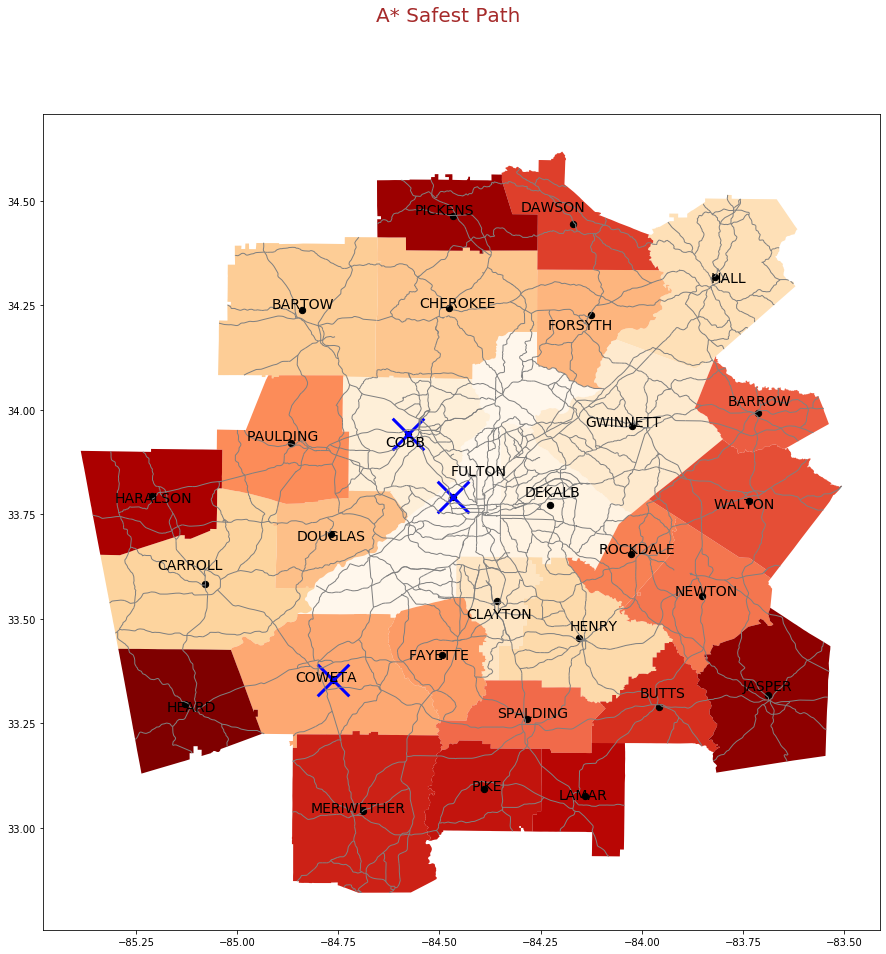

In [28]:
fig,ax=plt.subplots(figsize=(15,15))
base=at_county.plot(ax=ax,cmap='OrRd')
base2=points.plot(ax=base,color="black",markersize=40,marker="o")
base3=at_df.plot(ax=base2,color="blue",markersize=1000,marker="x",linewidth=3)
base4=mr.plot(ax=base3,color="grey",linewidth=1)
for idx, row in at_county.iterrows():
    plt.annotate(s=row['Label'], xy=row['coords'],
                 horizontalalignment='center',fontsize=14)
fig.suptitle('A* Safest Path',fontsize=20,color='brown')
plt.show()